## Boxing

In [1]:
import os
import json
import random
random.seed(1000)
from IPython.display import display
from PIL import Image, ImageDraw
import const
from sklearn.cluster import DBSCAN
import numpy as np 

In [2]:
IMG_PATH = const.IMG_PATH
VAL_JSON = const.VAL_JSON
ROS_OCR_JSON = const.ROS_OCR_JSON
AZURE_OCR_PATH = const.AZURE_OCR_PATH
#IMG_PATH = os.getenv('TVQA_IMG_PATH')
#VAL_JSON = os.getenv('TVQA_VAL_JSON')

baseline_pred = const.PRED_JSON
baseline_az_pred = const.PRED_NEW_JSON

In [3]:
def prepare_qid_info_map(tvqa_data):
    return {i['question_id']:i for i in tvqa_data['data']}

def check_ans(d, td):
    
    ans = d["answer"].replace(" 's'","'s'")
    s = set(td["answers"])
    if ans in s:
        return True
    return False

baseline_data = json.load(open(baseline_pred))
az_data = json.load(open(baseline_az_pred))
tvqa_val_data = json.load(open(VAL_JSON))
ros_ocr_data = {x["image_id"]:x["ocr_info"] for x in json.load(open(ROS_OCR_JSON))["data"]}
val_qid_info_map = prepare_qid_info_map(tvqa_val_data)

baseline_data_t = {x["question_id"]:x for x in baseline_data if check_ans(x,val_qid_info_map[x["question_id"]])}
baseline_data_f = {x["question_id"]:x for x in baseline_data if not check_ans(x,val_qid_info_map[x["question_id"]])}
az_data_t = {x["question_id"]:x for x in az_data if check_ans(x,val_qid_info_map[x["question_id"]])}
az_data_f = {x["question_id"]:x for x in az_data if not check_ans(x,val_qid_info_map[x["question_id"]])}
print(len(baseline_data_t),len(baseline_data_f),len(az_data_t),len(az_data_f))
bt = set(baseline_data_t.keys())
bf = set(baseline_data_f.keys())
zt = set(az_data_t.keys())
zf = set(az_data_f.keys())
print(len(bt&zt),len(bf&zf),len(bt&zf),len(bf&zt))


2163 2837 2392 2608
1637 2082 526 755


In [4]:
from random import randrange

def show_ros_ocr(im, data):
    imdraw = ImageDraw.Draw(im)
    IW, IH = im.size
    for entry in data:
        wd = entry["word"]
        box = entry["bounding_box"]
        w,h,tx,ty = box["width"]*IW, box["height"]*IH, box["top_left_x"]*IW, box["top_left_y"]*IH
        imdraw.rectangle([(tx,ty),(tx+w,ty+h)],width=3)
        #imdraw.text((tx+5,ty+5),wd)
    return im

def show_az_ocr(im, data, cluster_labels=[]):
    def draw_rec(imd,b,fil=(255,255,255),w=3):
        imd.line([(b[0],b[1]),(b[2],b[3])],fil,w)
        imd.line([(b[2],b[3]),(b[4],b[5])],fil,w)
        imd.line([(b[4],b[5]),(b[6],b[7])],fil,w)
        imd.line([(b[6],b[7]),(b[0],b[1])],fil,w)
    imdraw = ImageDraw.Draw(im)
    IW, IH = im.size
    if len(cluster_labels)>0:
        mn,mx = np.amin(cluster_labels),np.amax(cluster_labels)
        color_ls = [(randrange(150)+100,randrange(150)+100,randrange(150)+100) for x in range(mx+1)]
        color_ls.append((255,255,255))
    for cnt, entry in enumerate(data):
        lbox = entry["bounding_box"]
        if len(cluster_labels)>0:
            fil=color_ls[cluster_labels[cnt]]
        else:
            fil=(255,0,0)
        draw_rec(imdraw, lbox, fil=fil,w=5)
        for wentry in entry["words"]:
            wd = wentry["text"]
            wbox = wentry["bounding_box"]
            #draw_rec(imdraw,wbox)
            #imdraw.text((wbox[0]+5,wbox[1]+5),wd)
    return im

[(-1, 'F10'), (0, 'F12'), (0, '#13'), (1, 'F14'), (1, 'F15'), (2, 'Hola a todos los que formais elequipo dee 118 70:'), (2, 'imuchas gracias per la caminetal'), (2, 'En agradecimiento (aunque no creo demasiado'), (-1, '0'), (2, 'on estas conors ) os envio un boleto de loteria'), (2, 'con in numer "muy especial " para ver'), (2, 'con un poco - mucha suene, el dia 2ld'), (3, 'xtraordinario'), (2, 'agosto podeis celebrar alaro mas'), (2, 'el medio aniversario anual dee 11070'), (3, '11870'), (2, 'Que tengais mas bonitan vacaciones'), (3, 'SERIE 005'), (2, 'y que el 11870 continue an de kmen.'), (3, 'SORTEO'), (4, 'un saludo ,'), (3, '15 AGO 07'), (3, '15257 15:11'), (3, '06 AGO 07'), (3, '6,00 EUR'), (3, '26638320'), (4, 'Pili'), (3, '079-227-005-11870'), (3, '218-03527212-142'), (-1, "0 ( maripili, pa' la neb )")]


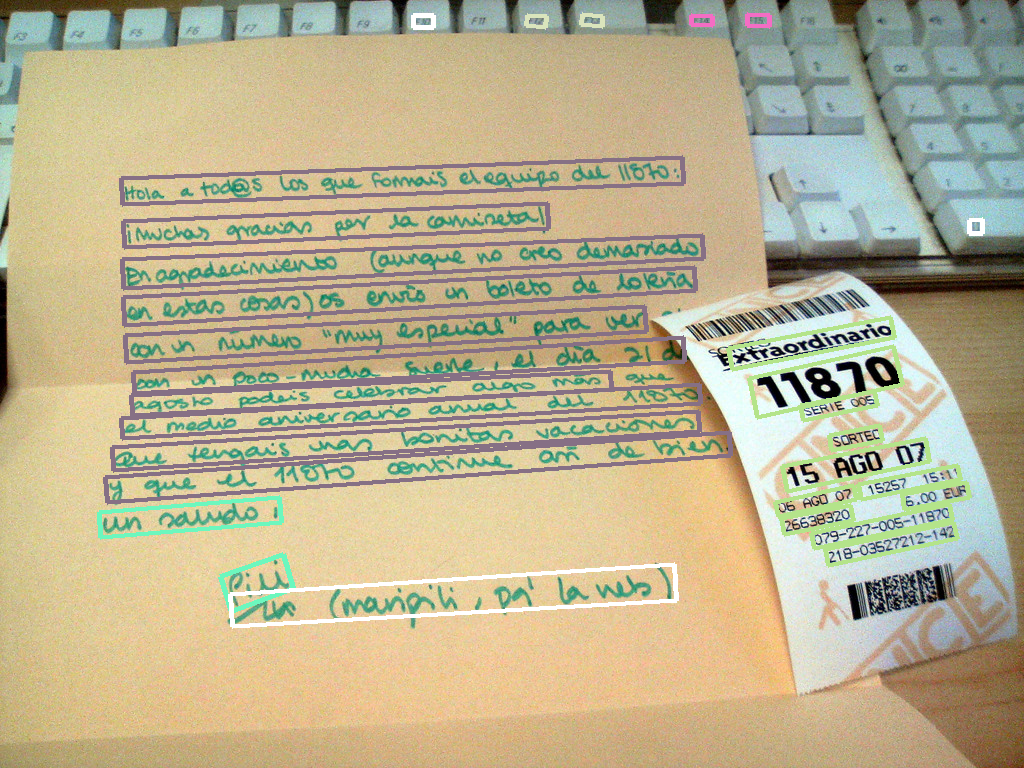

Question: what is the number of the card on right?
Ground truth: ['11870', '11870', '11870', '11870', '11870', '11870', '11870', 'nationals.com', '11870', '11870']

Azure: ['F10', 'F12', '#13', 'F14', 'F15', 'Hola a todos los que formais elequipo dee 118 70:', 'imuchas gracias per la caminetal', 'En agradecimiento (aunque no creo demasiado', '0', 'on estas conors ) os envio un boleto de loteria', 'con in numer "muy especial " para ver', 'con un poco - mucha suene, el dia 2ld', 'xtraordinario', 'agosto podeis celebrar alaro mas', 'el medio aniversario anual dee 11070', '11870', 'Que tengais mas bonitan vacaciones', 'SERIE 005', 'y que el 11870 continue an de kmen.', 'SORTEO', 'un saludo ,', '15 AGO 07', '15257 15:11', '06 AGO 07', '6,00 EUR', '26638320', 'Pili', '079-227-005-11870', '218-03527212-142', "0 ( maripili, pa' la neb )"]
Prediction: 118
Prediction source: ['OCR']


In [52]:
def get_box_feat(box):
    #feats = box
    feats = [np.mean(box[::2]),np.mean(box[1::2])]
    return feats
    
def box_dis(box1, box2):
    def dis(a,b):
        return np.sqrt(np.sum((a-b)*(a-b)))

    pts1 = box1.reshape(-1,2)
    pts2 = box2.reshape(-1,2)
    l = pts1.shape[0]
    dis_ls = []
    for i in range(l):
        for j in range(l):
            dis_ls.append(dis(pts1[i],pts2[j]))
    return np.amin(np.array(dis_ls))

# randomly choose examples
qid = random.choice(list(zf))
pred_info = az_data_f[qid]
qid = pred_info['question_id']
iid = pred_info['image_id']
gt_info = val_qid_info_map[qid]
pred_im_path = os.path.join(IMG_PATH, '{}.jpg'.format(gt_info['image_id']))

# visualize
'''
orig_pred_info = baseline_data_t[qid]
im = Image.open(pred_im_path)
im_ros = show_ros_ocr(im,ros_ocr_data[iid])
ros_pred_text = [x["word"] for x in ros_ocr_data[iid]]
display(im_ros)
'''
im = Image.open(pred_im_path)
az_ocr_data = json.load(open(os.path.join(AZURE_OCR_PATH,iid+".json")))

line_ls = az_ocr_data["lines"]
box_ls = [get_box_feat(line["bounding_box"]) for line in line_ls]
box_arr = np.array(box_ls)

clustering = DBSCAN(eps=100, metric=box_dis, min_samples=2).fit(box_arr)
print([x for x in zip(clustering.labels_, [x["text"] for x in line_ls])])

im_az = show_az_ocr(im,line_ls,clustering.labels_)
az_pred_text = [x["text"] for x in line_ls]
display(im_az)


print('Question: {}'.format(gt_info['question']))
print('Ground truth: {}'.format(gt_info['answers']))
print()
'''
print("Rosetta:", ros_pred_text)
print("Old Prediction: {}".format(orig_pred_info["answer"]))
print('Old Prediction source: {}'.format(orig_pred_info['pred_source']))
print()
'''
print("Azure:", az_pred_text)
print('Prediction: {}'.format(pred_info['answer']))
print('Prediction source: {}'.format(pred_info['pred_source']))



